In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализации
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

Объединение данных

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Добавляем колонку Survived в test из gender_submission
test = test.merge(gender_submission, on='PassengerId', how='left')

# Объединяем в один датасет
full = pd.concat([train, test], ignore_index=True)
print(f"Размер полного датасета: {full.shape}")
print(full.head())

Размер полного датасета: (1309, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0           

Анализ пропусков

In [13]:

print(full.isnull().sum())

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


Анализ возраста

Средний и медианный возраст по полу:
         mean  median  count
Sex                         
female  28.69    27.0    388
male    30.59    28.0    658


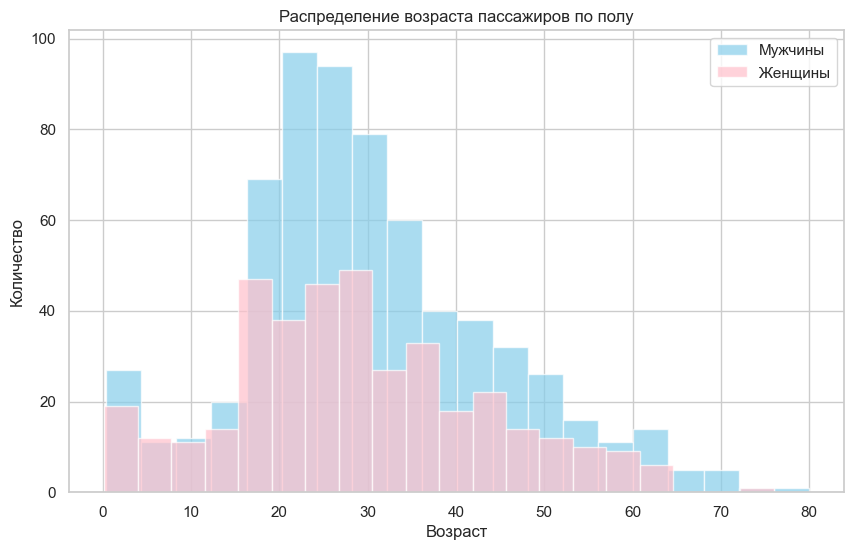

Пропусков в Age после заполнения: 0


In [14]:

# Статистика по полу
age_stats = full.groupby('Sex')['Age'].agg(['mean', 'median', 'count'])
print("Средний и медианный возраст по полу:")
print(age_stats.round(2))

# Графики распределения возраста
plt.figure()
full[full['Sex'] == 'male']['Age'].hist(bins=20, alpha=0.7, label='Мужчины', color='skyblue')
full[full['Sex'] == 'female']['Age'].hist(bins=20, alpha=0.7, label='Женщины', color='pink')
plt.title('Распределение возраста пассажиров по полу')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend()
plt.show()

# Заполнение пропусков в Age медианой по группам Sex + Pclass
full['Age'] = full.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
#full['Age'].fillna(full['Age'].median(), inplace=True)  # на всякий случай остатки
print(f"Пропусков в Age после заполнения: {full['Age'].isnull().sum()}")

Категоризация возраста

In [15]:

bins = [0, 18, 60, full['Age'].max()]
labels = ['Дети (<18)', 'Средний возраст (18-60)', 'Старшие (>60)']
full['Age_Cat'] = pd.cut(full['Age'], bins=bins, labels=labels, include_lowest=True)
print(full['Age_Cat'].value_counts().sort_index())

Age_Cat
Дети (<18)                  193
Средний возраст (18-60)    1083
Старшие (>60)                33
Name: count, dtype: int64


Анализ тарифов (Fare)

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64


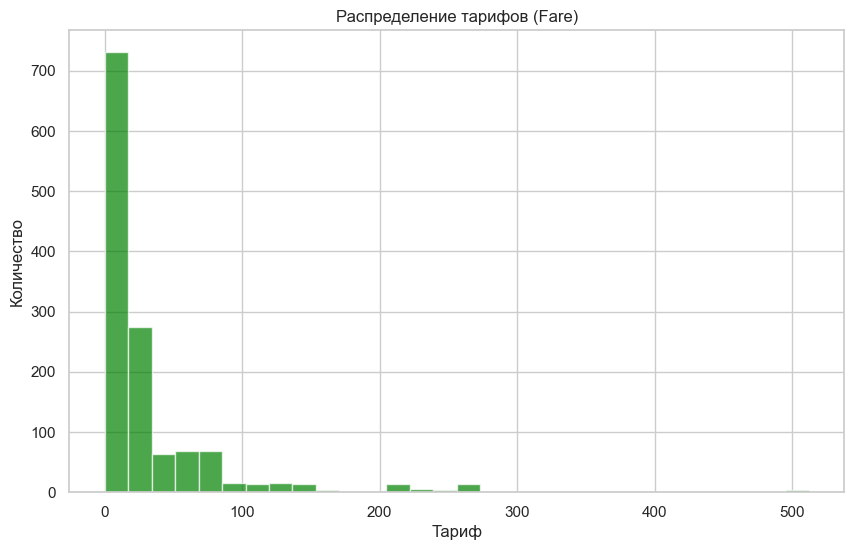


Статистика Fare для 1 класса:
count    323.000000
mean      87.508992
std       80.447178
min        0.000000
25%       30.695800
50%       60.000000
75%      107.662500
max      512.329200
Name: Fare, dtype: float64

Подозрительные записи в 1-м классе (Fare < 20): 8
      PassengerId                                   Name  Pclass  Fare  \
263           264                  Harrison, Mr. William       1   0.0   
633           634          Parr, Mr. William Henry Marsh       1   0.0   
806           807                 Andrews, Mr. Thomas Jr       1   0.0   
815           816                       Fry, Mr. Richard       1   0.0   
822           823        Reuchlin, Jonkheer. John George       1   0.0   
872           873               Carlsson, Mr. Frans Olof       1   5.0   
1157         1158  Chisholm, Mr. Roderick Robert Crispin       1   0.0   
1263         1264                Ismay, Mr. Joseph Bruce       1   0.0   

      Ticket Embarked  
263   112059        S  
633   112052    

In [16]:

print(full['Fare'].describe())

# Гистограмма тарифов
plt.figure()
full['Fare'].hist(bins=30, color='green', alpha=0.7)
plt.title('Распределение тарифов (Fare)')
plt.xlabel('Тариф')
plt.ylabel('Количество')
plt.show()

# Только 1 класс
first_class = full[full['Pclass'] == 1]
print("\nСтатистика Fare для 1 класса:")
print(first_class['Fare'].describe())

# Подозрительные записи: очень низкий тариф в 1 классе (< 20)
suspicious_fare = first_class[first_class['Fare'] < 20]
print(f"\nПодозрительные записи в 1-м классе (Fare < 20): {len(suspicious_fare)}")
print(suspicious_fare[['PassengerId', 'Name', 'Pclass', 'Fare', 'Ticket', 'Embarked']])

Самые большие семьи

In [17]:

full['Family_Size'] = full['SibSp'] + full['Parch'] + 1
full['Surname'] = full['Name'].str.split(',').str[0]

# Группируем по фамилии и билету (для точности)
families = full.groupby(['Surname', 'Pclass', 'Ticket']).size().reset_index(name='Group_Size')
largest_families = families.sort_values('Group_Size', ascending=False).head(5)
print("Топ-5 самых больших семей:")
print(largest_families)

# Пример детального просмотра семьи Sage
sage_family = full[full['Surname'] == 'Sage']
print("\nСемья Sage:")
print(sage_family[['PassengerId', 'Name', 'Survived', 'Age', 'Pclass', 'Family_Size']])

Топ-5 самых больших семей:
       Surname  Pclass    Ticket  Group_Size
827       Sage       3  CA. 2343          11
355    Goodwin       3   CA 2144           8
42     Asplund       3    347077           7
26   Andersson       3    347082           7
788       Rice       3    382652           6

Семья Sage:
      PassengerId                               Name  Survived   Age  Pclass  \
159           160         Sage, Master. Thomas Henry         0  25.0       3   
180           181       Sage, Miss. Constance Gladys         0  22.0       3   
201           202                Sage, Mr. Frederick         0  25.0       3   
324           325           Sage, Mr. George John Jr         0  25.0       3   
792           793            Sage, Miss. Stella Anna         0  22.0       3   
846           847           Sage, Mr. Douglas Bullen         0  25.0       3   
863           864  Sage, Miss. Dorothy Edith "Dolly"         0  22.0       3   
1079         1080                    Sage, Miss. A

Выявление закономерностей

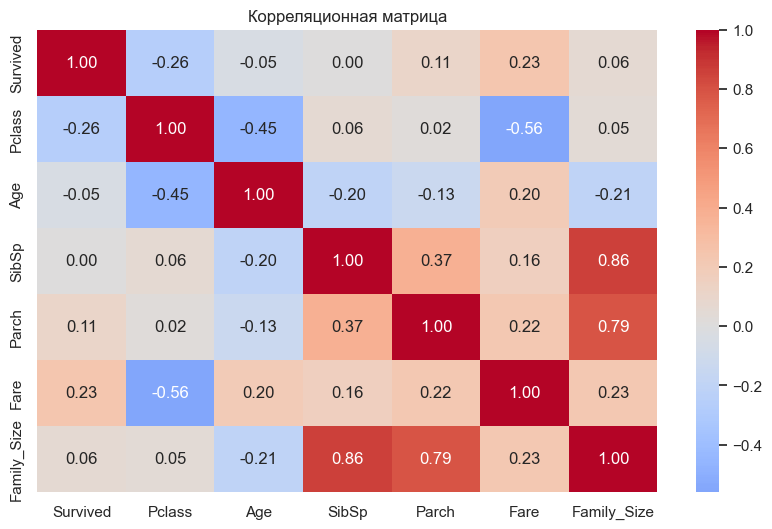


Выживаемость по полу:
Sex
female    0.82618
male      0.12930
Name: Survived, dtype: float64

Выживаемость по классу:
Pclass
1    0.575851
2    0.422383
3    0.269394
Name: Survived, dtype: float64

Выживаемость по возрастной категории:
Age_Cat
Дети (<18)                 0.487047
Средний возраст (18-60)    0.361034
Старшие (>60)              0.272727
Name: Survived, dtype: float64

Выживаемость по размеру семьи:
Family_Size
1     0.292405
2     0.531915
3     0.559748
4     0.720930
5     0.227273
6     0.200000
7     0.312500
8     0.125000
11    0.181818
Name: Survived, dtype: float64

Выживаемость по порту посадки:
Embarked
C    0.492593
Q    0.439024
S    0.333698
Name: Survived, dtype: float64

Выживаемость по полу и классу:
Pclass         1         2         3
Sex                                 
female  0.979167  0.943396  0.666667
male    0.251397  0.099415  0.095335


In [20]:
# Корреляционная матрица
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size']
corr = full[numeric_cols].corr()

plt.figure()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

# Сводные таблицы по ключевым признакам
print("\nВыживаемость по полу:")
print(full.groupby('Sex')['Survived'].mean())

print("\nВыживаемость по классу:")
print(full.groupby('Pclass')['Survived'].mean())

print("\nВыживаемость по возрастной категории:")
print(full.groupby('Age_Cat', observed=False)['Survived'].mean())
#print(full.groupby('Age_Cat')['Survived'].mean())

print("\nВыживаемость по размеру семьи:")
print(full.groupby('Family_Size')['Survived'].mean())

print("\nВыживаемость по порту посадки:")
print(full.groupby('Embarked')['Survived'].mean())

# Кросс-таблица пол + класс
print("\nВыживаемость по полу и классу:")
pivot_sex_pclass = full.pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
print(pivot_sex_pclass)

Простейшие модели прогноза

In [24]:
# 1. Вероятностная модель
print("\nПостроение вероятностной модели...")

# Только тренировочные данные (реальные Survived)
train_data = full[full['PassengerId'] <= 891].copy()

# Вероятности по группам Sex + Pclass + Age_Cat (только на train)
prob_groups = (train_data.groupby(['Sex', 'Pclass', 'Age_Cat'], observed=False)['Survived']
               .mean()
               .rename('Prob_Surv')
               .reset_index())

print("Примеры рассчитанных вероятностей:")
display(prob_groups.head(10))  # display вместо print для красивого вывода в Jupyter

# Важно: удаляем старый столбец Prob_Surv, если он уже есть (чтобы избежать конфликта)
if 'Prob_Surv' in full.columns:
    full = full.drop(columns=['Prob_Surv'])

# Присоединяем рассчитанные вероятности
full = full.merge(prob_groups, on=['Sex', 'Pclass', 'Age_Cat'], how='left')

# Заполняем редкие/отсутствующие комбинации общей вероятностью выживания на train
overall_survival_rate = train_data['Survived'].mean()
full['Prob_Surv'] = full['Prob_Surv'].fillna(overall_survival_rate)

print(f"Общая вероятность выживания (заполнение пропусков): {overall_survival_rate:.4f}")

# Бинарный прогноз по вероятностной модели
full['Model_Prob_Surv'] = (full['Prob_Surv'] > 0.5).astype(int)

accuracy_prob = (full['Model_Prob_Surv'] == full['Survived']).mean()
print(f"Точность вероятностной модели: {accuracy_prob:.4f}")

# 2. Модель на логических правилах
print("\nПостроение модели на логических правилах...")

def logical_survival_rule(row):
    # Основное историческое правило: "женщины и дети сначала"
    if row['Sex'] == 'female':
        return 1
    if row['Age'] < 18:  # все дети выживают в этой простой модели
        return 1
    # Небольшое уточнение: мальчики из 1 класса иногда выживали
    if row['Pclass'] == 1 and row['Sex'] == 'male' and row['Age'] < 15:
        return 1
    return 0

# Удаляем старый столбец, если был
if 'Model_Logical_Surv' in full.columns:
    full = full.drop(columns=['Model_Logical_Surv'])

full['Model_Logical_Surv'] = full.apply(logical_survival_rule, axis=1)

accuracy_logical = (full['Model_Logical_Surv'] == full['Survived']).mean()
print(f"Точность модели на логических правилах: {accuracy_logical:.4f}")

# Итоговое сравнение
print("\n=== ИТОГО ===")
print(f"Вероятностная модель (Sex + Pclass + Age_Cat): {accuracy_prob:.4f}")
print(f"Логическая модель (женщины и дети):           {accuracy_logical:.4f}")

# Сохранение
full.to_csv('titanic_full_processed.csv', index=False)
print("\nОбработка завершена. Результат сохранён в 'titanic_full_processed.csv'")


Построение вероятностной модели...
Примеры рассчитанных вероятностей:


,Sex,Pclass,Age_Cat,Prob_Surv
0,female,1,Дети (<18),0.909091
1,female,1,Средний возраст (18-60),0.975309
2,female,1,Старшие (>60),1.000000
3,female,2,Дети (<18),1.000000
4,female,2,Средний возраст (18-60),0.903226
5,female,2,Старшие (>60),NaN
6,female,3,Дети (<18),0.511628
7,female,3,Средний возраст (18-60),0.490000
8,female,3,Старшие (>60),1.000000
9,male,1,Дети (<18),0.800000


Общая вероятность выживания (заполнение пропусков): 0.3838
Точность вероятностной модели: 0.8105

Построение модели на логических правилах...
Точность модели на логических правилах: 0.8273

=== ИТОГО ===
Вероятностная модель (Sex + Pclass + Age_Cat): 0.8105
Логическая модель (женщины и дети):           0.8273

Обработка завершена. Результат сохранён в 'titanic_full_processed.csv'
